In [1]:
!conda install -y gdown

Retrieving notices: ...working... done
Channels:
 - rapidsai
 - nvidia
 - conda-forge
 - defaults
 - pytorch
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2024.6.2           |     pyhd8ed1ab_0         157 KB  conda-forge
    filelock-3.15.1            |     pyhd8ed1ab_0          17 KB  conda-forge
    gdown-5.2.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    openssl-3.3.1              |       h4ab18f5_0         2.8 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.15.1-pyhd8ed1ab_0 
  gdown              conda-forge/noarch::gdow

In [2]:
import os
import zipfile

In [3]:
!gdown --id 1ZLt2pF9PSAndUVsO8TJOstGlc2KSy1DQ

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ZLt2pF9PSAndUVsO8TJOstGlc2KSy1DQ
From (redirected): https://drive.google.com/uc?id=1ZLt2pF9PSAndUVsO8TJOstGlc2KSy1DQ&confirm=t&uuid=b08f79f8-360d-45aa-b617-a016135fe71b
To: /kaggle/working/ai_real_fake_dataset.zip
100%|███████████████████████████████████████| 3.83G/3.83G [00:27<00:00, 139MB/s]


In [5]:
zip_file_path = '/kaggle/working/ai_real_fake_dataset.zip'
extraction_path = '/kaggle/working/ai_real_fake_dataset'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Function to count folders and images
def count_folders_and_images(directory):
    folder_count = 0
    image_count = 0
    for root, dirs, files in os.walk(directory):
        folder_count += len(dirs)
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif')):
                image_count += 1
    return folder_count, image_count

# Get the counts
folders, images = count_folders_and_images(extraction_path)

print(f"Number of folders: {folders}")
print(f"Number of images: {images}")

Number of folders: 3
Number of images: 93998


In [87]:
folders, images = count_folders_and_images("/kaggle/working/ai_real_fake_dataset/Datasets/Fake")

print(f"Number of folders: {folders}")
print(f"Number of images: {images}")

Number of folders: 0
Number of images: 47000


In [101]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import datasets, models, transforms

import os
import pandas as pd
from PIL import Image

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, annotations, root_dir, transform=None):
        self.annotations = annotations
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(int(self.annotations.iloc[idx, 1]))

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create annotations dataframe
def create_annotations(extraction_path):
    data = []
    for label, category in enumerate(['Fake', 'Real']):
        category_path = os.path.join(extraction_path, category)
        for img_name in os.listdir(category_path):
            data.append([os.path.join(category, img_name), label])
    return pd.DataFrame(data, columns=['image', 'label'])

extraction_path = '/kaggle/working/ai_real_fake_dataset/Datasets'
annotations = create_annotations(extraction_path)

# Load the dataset
dataset = CustomDataset(annotations, extraction_path, transform=transform)

# Split the dataset into train, validation, and test sets
"""
train_size = int(0.9 * len(dataset))
val_test_size = len(dataset) - train_size
val_size = int(0.05 * val_test_size)
test_size = val_test_size - val_size
"""
train_size = int(0.95 * len(dataset))
val_size = int(0.025 * len(dataset))
test_size = len(dataset) - train_size - val_size


trainset, valset, testset = random_split(dataset, [train_size, val_size, test_size])

# Load the datasets into dataloaders
trainloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=8, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=8, shuffle=True, num_workers=2)

In [20]:
print("Train set size: ", len(trainset))
print("Validation set size: ", len(valset))
print("Test set size: ", len(testset))

Train set size:  89298
Validation set size:  2349
Test set size:  2351


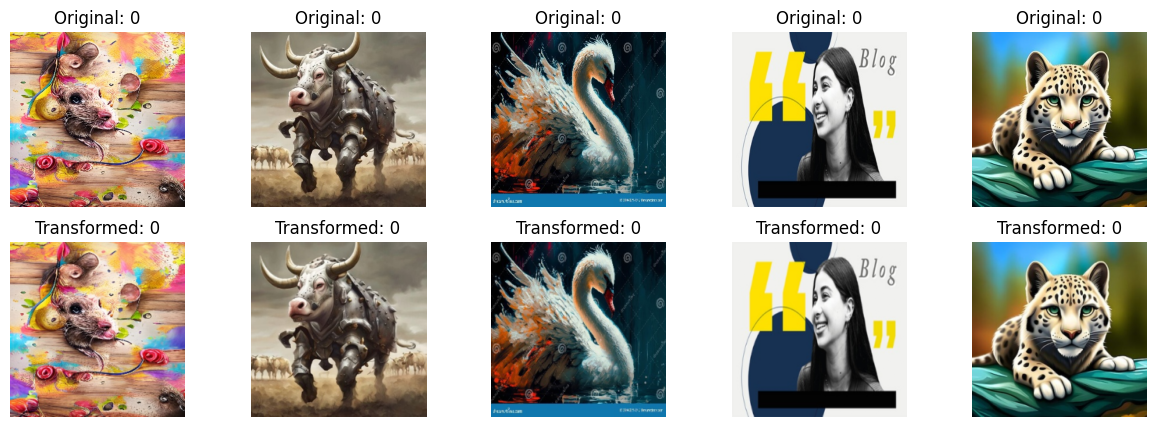

In [12]:
# Function to visualize images before and after transformation
def show_images(dataset, num_images=5):
    fig, axs = plt.subplots(2, num_images, figsize=(15, 5))

    for i in range(num_images):
        # Original image
        img_path = os.path.join(dataset.root_dir, dataset.annotations.iloc[i, 0])
        image = Image.open(img_path).convert("RGB")
        axs[0, i].imshow(image)
        axs[0, i].set_title(f"Original: {dataset.annotations.iloc[i, 1]}")
        axs[0, i].axis('off')
        
        # Transformed image
        transformed_image, label = dataset[i]
        transformed_image = transformed_image.permute(1, 2, 0).numpy()
        axs[1, i].imshow(transformed_image)
        axs[1, i].set_title(f"Transformed: {label.item()}")
        axs[1, i].axis('off')
    
    plt.show()

# Show sample images before and after transformation
show_images(dataset, num_images=5)

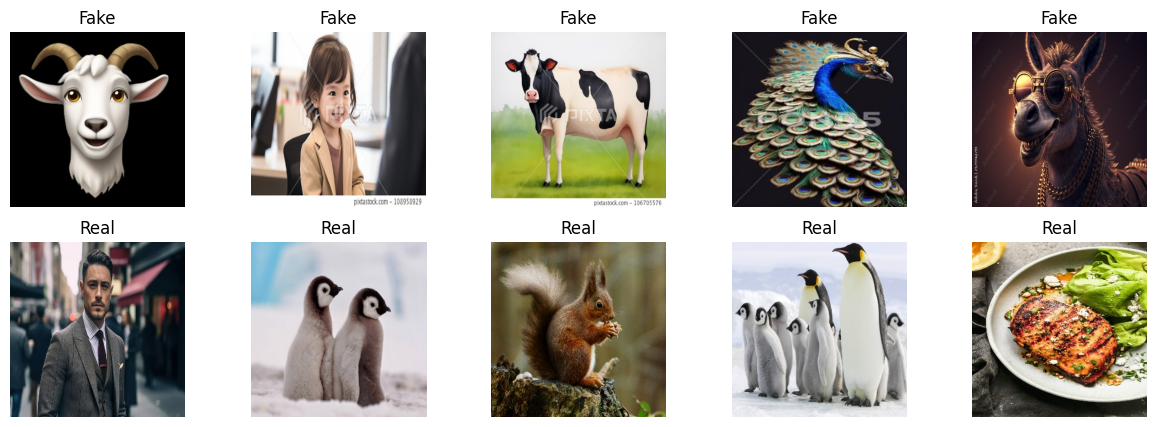

In [13]:
# Function to show random 5 images from each class
def show_random_images_by_class(dataset, num_images=5):
    fake_images = dataset.annotations[dataset.annotations['label'] == 0].sample(num_images)
    real_images = dataset.annotations[dataset.annotations['label'] == 1].sample(num_images)

    fig, axs = plt.subplots(2, num_images, figsize=(15, 5))
    
    for i, (idx, row) in enumerate(fake_images.iterrows()):
        img_path = os.path.join(dataset.root_dir, row['image'])
        image = Image.open(img_path).convert("RGB")
        axs[0, i].imshow(image)
        axs[0, i].set_title("Fake")
        axs[0, i].axis('off')
    
    for i, (idx, row) in enumerate(real_images.iterrows()):
        img_path = os.path.join(dataset.root_dir, row['image'])
        image = Image.open(img_path).convert("RGB")
        axs[1, i].imshow(image)
        axs[1, i].set_title("Real")
        axs[1, i].axis('off')
    
    plt.show()

# Show random 5 images from each class
show_random_images_by_class(dataset, num_images=5)

In [22]:
def train(net, train_dataloader, val_dataloader, device, num_epochs, lr=0.1, momentum=0.8, step_size=5, gamma=0.5, verbose=True):
    train_acc_history = []
    val_acc_history = []
    train_history = []
    val_history = []
 
    net = net.to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
 
    for e in range(num_epochs):
        running_train_correct = 0.0
        running_train_loss = 0.0
        running_train_count = 0.0
        running_val_correct = 0.0
        running_val_loss = 0.0
        running_val_count = 0.0
 
        net.train()
        for i, (inputs, labels) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.reshape(-1, 1).float()
 
            optimizer.zero_grad()
            outs = net(inputs)
            train_loss = F.binary_cross_entropy(outs, labels)
            train_loss.backward()
            optimizer.step()
 
            running_train_loss += train_loss.item()
            running_train_count += 1
            preds = outs >= 0.5
            running_train_correct += (preds == labels).sum().item()
 
        train_loss = running_train_loss / running_train_count
        train_acc = 100 * (running_train_correct / len(train_dataloader.dataset))
 
        net.eval()
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = labels.reshape(-1, 1).float()
 
                outs = net(inputs)
                val_loss = F.binary_cross_entropy(outs, labels)
 
                running_val_loss += val_loss.item()
                running_val_count += 1
                preds = outs >= 0.5
                running_val_correct += (preds == labels).sum().item()
 
        val_loss = running_val_loss / running_val_count
        val_acc = 100 * (running_val_correct / len(val_dataloader.dataset))
 
        if verbose:
            print(f'[Epoch {e+1}/{num_epochs}] Training loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}')
            print(f'Training accuracy: {train_acc:.2f}%, Validation accuracy: {val_acc:.2f}%')
 
        train_history.append(train_loss)
        val_history.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
 
        scheduler.step()
 
    return train_history, val_history, train_acc_history, val_acc_history

In [48]:
def evaluate(net, test_dataloader, device):
    running_correct = 0.0
    running_count = 0.0
    net.eval()
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.reshape(-1, 1).float()
 
            outs = net(inputs)
            preds = outs >= 0.5
            running_correct += (preds == labels).sum().item()
            running_count += len(labels)
    return 100 * (running_correct / running_count)

def f1_score_(net, test_dataloader, device):
    y_true = []
    y_pred = []
    net.eval()
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.reshape(-1, 1).float()
 
            outs = net(inputs)
            preds = (outs >= 0.5).cpu().numpy()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds)
    
    y_true = np.array(y_true).astype(int)
    y_pred = np.array(y_pred).astype(int)
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return precision, recall, f1

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [27]:
net = build_network()
num_epochs = 20

In [36]:
trainloader16 = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
valloader16 = DataLoader(valset, batch_size=16, shuffle=True, num_workers=2)
testloader16 = DataLoader(testset, batch_size=16, shuffle=True, num_workers=2)
#testvalloader16 = DataLoader(testvalset, batch_size=6, shuffle=True, num_workers=2)

x_batch_train, y_batch_train = next(iter(trainloader16))
print(f'Shape of {x_batch_train.shape}')
print(f'Shape of {y_batch_train.shape}')

x_batch_train, y_batch_train = next(iter(valloader16))
print(f'Shape of {x_batch_train.shape}')
print(f'Shape of {y_batch_train.shape}')

x_batch_test, y_batch_test = next(iter(testloader16))
print(f'Shape of {x_batch_test.shape}')
print(f'Shape of {y_batch_test.shape}')



Shape of torch.Size([16, 3, 224, 224])
Shape of torch.Size([16])
Shape of torch.Size([16, 3, 224, 224])
Shape of torch.Size([16])
Shape of torch.Size([16, 3, 224, 224])
Shape of torch.Size([16])


In [37]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [38]:
from torchinfo import summary

In [39]:
alexnet = AlexNet()

# Print the architecture to verify
summary(alexnet, input_size=(16, 3, 224, 224), col_names=["output_size", "num_params", "mult_adds"])


Layer (type:depth-idx)                   Output Shape              Param #                   Mult-Adds
AlexNet                                  [16, 1]                   --                        --
├─Sequential: 1-1                        [16, 256, 5, 5]           --                        --
│    └─Conv2d: 2-1                       [16, 96, 54, 54]          34,944                    1,630,347,264
│    └─ReLU: 2-2                         [16, 96, 54, 54]          --                        --
│    └─MaxPool2d: 2-3                    [16, 96, 26, 26]          --                        --
│    └─Conv2d: 2-4                       [16, 256, 26, 26]         614,656                   6,648,119,296
│    └─ReLU: 2-5                         [16, 256, 26, 26]         --                        --
│    └─MaxPool2d: 2-6                    [16, 256, 12, 12]         --                        --
│    └─Conv2d: 2-7                       [16, 384, 12, 12]         885,120                   2,039,316,480


In [40]:
train_history_alex, val_history_alex, train_acc_history_alex, val_acc_history_alex = train(alexnet, trainloader16,valloader16, device, num_epochs=15, lr=0.01, step_size=5, gamma=0.1)

100%|██████████| 5582/5582 [03:00<00:00, 30.90it/s]


[Epoch 1/15] Training loss: 0.5644, Validation loss: 0.5230
Training accuracy: 69.34%, Validation accuracy: 74.80%


100%|██████████| 5582/5582 [03:00<00:00, 30.97it/s]


[Epoch 2/15] Training loss: 0.3553, Validation loss: 0.1745
Training accuracy: 84.24%, Validation accuracy: 93.23%


100%|██████████| 5582/5582 [03:01<00:00, 30.73it/s]


[Epoch 3/15] Training loss: 0.1380, Validation loss: 0.0792
Training accuracy: 94.53%, Validation accuracy: 96.81%


100%|██████████| 5582/5582 [02:59<00:00, 31.03it/s]


[Epoch 4/15] Training loss: 0.0547, Validation loss: 0.0221
Training accuracy: 97.72%, Validation accuracy: 98.89%


100%|██████████| 5582/5582 [03:00<00:00, 30.99it/s]


[Epoch 5/15] Training loss: 0.0267, Validation loss: 0.0164
Training accuracy: 98.73%, Validation accuracy: 99.06%


100%|██████████| 5582/5582 [03:00<00:00, 30.98it/s]


[Epoch 6/15] Training loss: 0.0117, Validation loss: 0.0127
Training accuracy: 99.22%, Validation accuracy: 99.15%


  7%|▋         | 386/5582 [00:12<02:38, 32.77it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 5582/5582 [03:00<00:00, 30.95it/s]


[Epoch 7/15] Training loss: 0.0113, Validation loss: 0.0126
Training accuracy: 99.21%, Validation accuracy: 99.06%


100%|██████████| 5582/5582 [03:01<00:00, 30.80it/s]


[Epoch 8/15] Training loss: 0.0113, Validation loss: 0.0126
Training accuracy: 99.21%, Validation accuracy: 99.06%


100%|██████████| 5582/5582 [03:00<00:00, 30.97it/s]


[Epoch 9/15] Training loss: 0.0112, Validation loss: 0.0122
Training accuracy: 99.23%, Validation accuracy: 99.15%


100%|██████████| 5582/5582 [02:59<00:00, 31.07it/s]


[Epoch 10/15] Training loss: 0.0111, Validation loss: 0.0121
Training accuracy: 99.24%, Validation accuracy: 99.15%


100%|██████████| 5582/5582 [03:00<00:00, 31.00it/s]


[Epoch 11/15] Training loss: 0.0111, Validation loss: 0.0121
Training accuracy: 99.25%, Validation accuracy: 99.15%


100%|██████████| 5582/5582 [03:00<00:00, 30.87it/s]


[Epoch 12/15] Training loss: 0.0111, Validation loss: 0.0121
Training accuracy: 99.25%, Validation accuracy: 99.15%


100%|██████████| 5582/5582 [03:00<00:00, 30.86it/s]


[Epoch 13/15] Training loss: 0.0111, Validation loss: 0.0121
Training accuracy: 99.26%, Validation accuracy: 99.15%


100%|██████████| 5582/5582 [02:59<00:00, 31.07it/s]


[Epoch 14/15] Training loss: 0.0111, Validation loss: 0.0120
Training accuracy: 99.24%, Validation accuracy: 99.15%


100%|██████████| 5582/5582 [02:58<00:00, 31.24it/s]


[Epoch 15/15] Training loss: 0.0111, Validation loss: 0.0120
Training accuracy: 99.23%, Validation accuracy: 99.15%


In [43]:
evaluate(alexnet, testloader16, device)

99.53211399404509

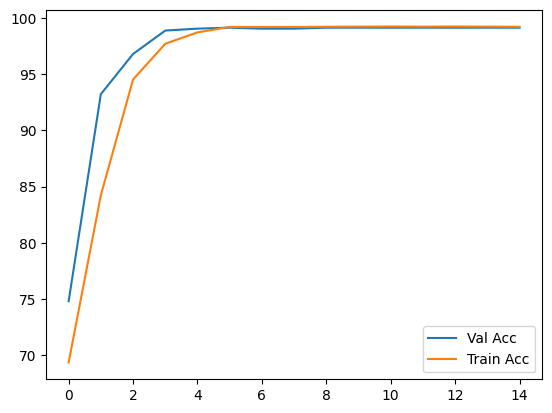

In [45]:
import matplotlib.pyplot as plt

plt.plot(val_acc_history_alex, label='Val Acc')
plt.plot(train_acc_history_alex, label='Train Acc')
plt.legend()
plt.show()

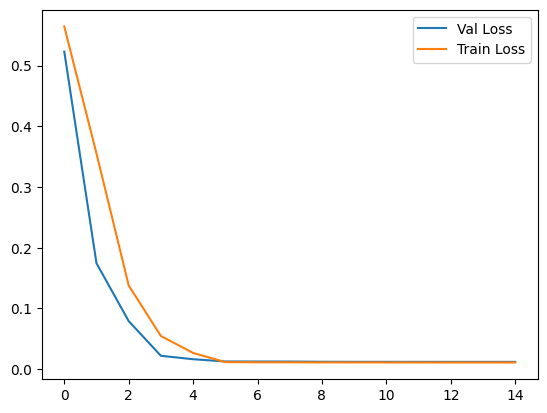

In [46]:
import matplotlib.pyplot as plt

plt.plot(val_history_alex, label='Val Loss')
plt.plot(train_history_alex, label='Train Loss')
plt.legend()
plt.show()

In [49]:
def f1(net, dataloader, device):
    # set to evaluation mode
    net.eval()
    all_targets = []
    all_predictions = []
    all_probs = []

    for inputs, targets in dataloader:

            # transfer to the GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # perform prediction
            with torch.no_grad():
                outputs = net(inputs)
                predicted = (outputs >= 0.5).float()

                # update all_targets and all_predictions
                all_targets.extend(targets.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                all_probs.extend(outputs.cpu().numpy())
                
    all_targets = np.array(all_targets)     
    all_predictions = np.array(all_predictions)
    all_probs = np.array(all_probs)
    
    all_targets = torch.tensor(all_targets)
    all_predictions = torch.tensor(all_predictions)
    
    #Accuracy
    accuracy = accuracy_score(all_targets, all_predictions)
    print('Accuracy:', accuracy)
    
    #ROC Curve
    fpr, tpr, thresholds = roc_curve(all_targets, all_probs)
    roc_auc = auc(fpr, tpr)

    #F1
    cm = confusion_matrix(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions)     
    recall = recall_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions)
    
    print('confusion_matrix: ', cm)
    print('precision: ', precision)
    print('recall: ', recall)
    print('f1 score: ', f1)
    
    #Precision Recall Curve
    precision, recall, _ = precision_recall_curve(all_targets, all_probs)
    pr_auc = auc(recall, precision)
    
    #Draw Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm) # Then just plot it: 
    disp.plot() # And show it: 
    plt.show()
    return roc_auc, fpr, tpr, pr_auc, recall, precision

In [50]:
final_model = alexnet

In [52]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score

Accuracy: 0.9953211399404509
confusion_matrix:  [[1181   11]
 [   0 1159]]
precision:  0.9905982905982906
recall:  1.0
f1 score:  0.995276942893946


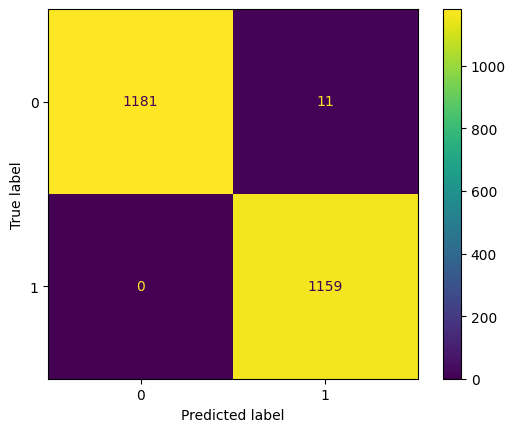

In [53]:
roc_auc, fpr, tpr, pr_auc, recall, precision = f1(final_model, testloader16, device)

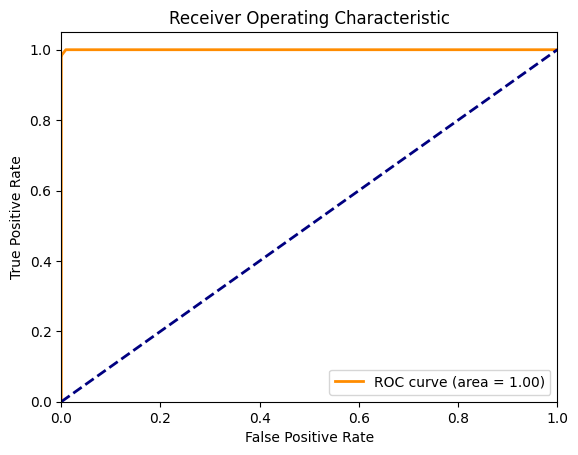

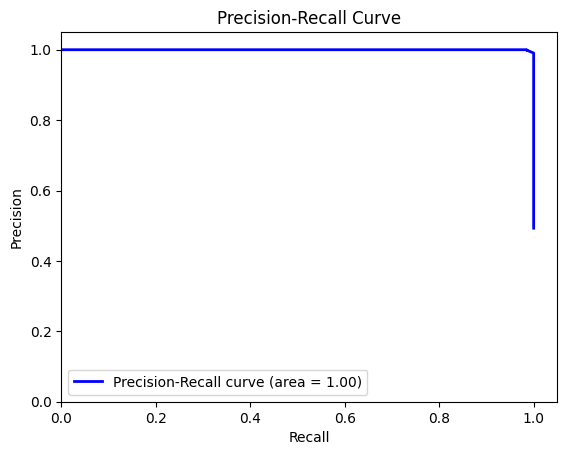

In [54]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [55]:
torch.save(final_model, '/kaggle/working/ai_imageclassifier_entire_1.pth')

# Save the model's state dictionary
torch.save(final_model.state_dict(), '/kaggle/working/ai_imageclassifier_1.pth')

In [64]:
# Evaluate the model's accuracy
accuracy = evaluate(final_model, testloader, device)
print("Accuracy:", accuracy)

# Compute precision, recall, and F1 score
precision, recall, f1 = f1_score_(final_model, testloader, device)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 99.53211399404509
Precision: 0.9905982905982906
Recall: 1.0
F1 Score: 0.995276942893946


In [81]:
print(extraction_path+"/Real")

/kaggle/working/ai_real_fake_dataset/Datasets/Real


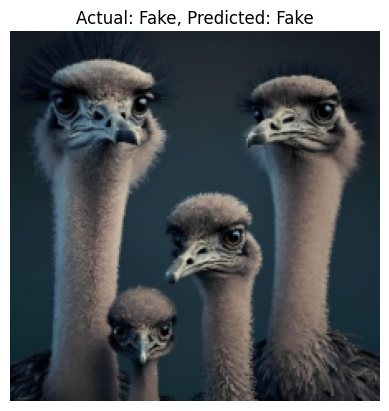

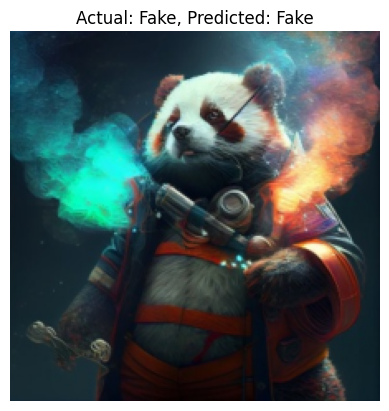

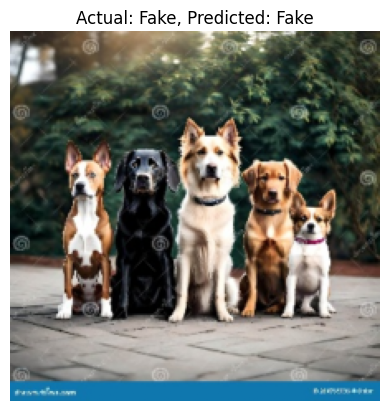

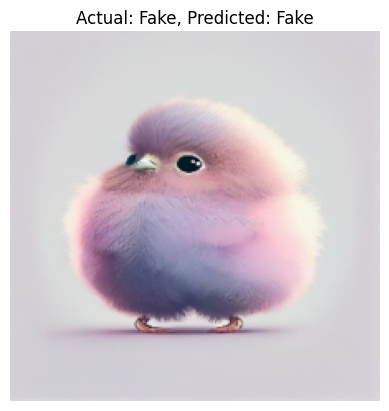

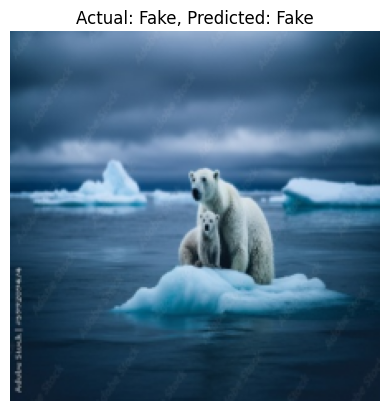

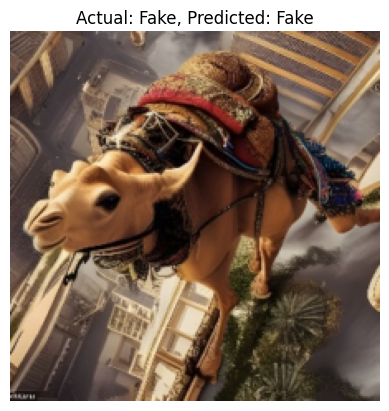

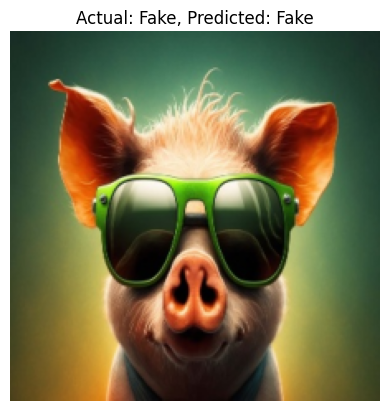

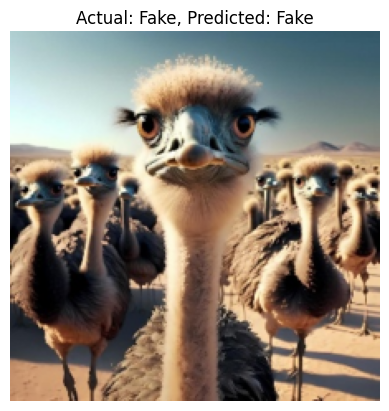

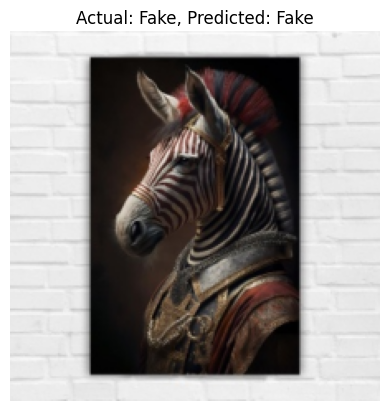

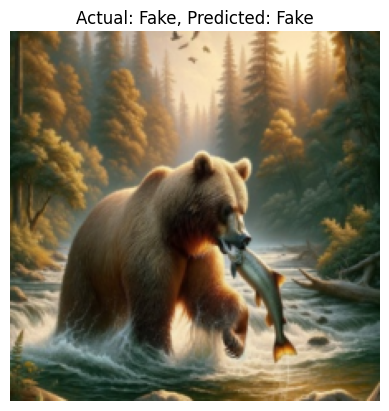

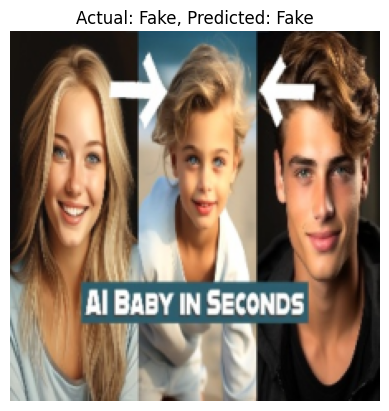

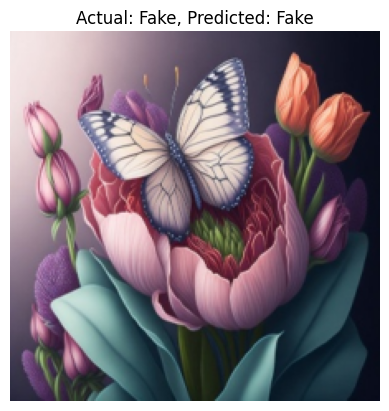

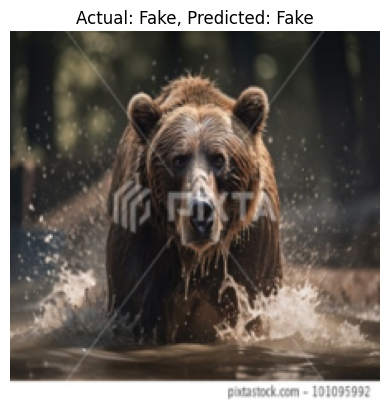

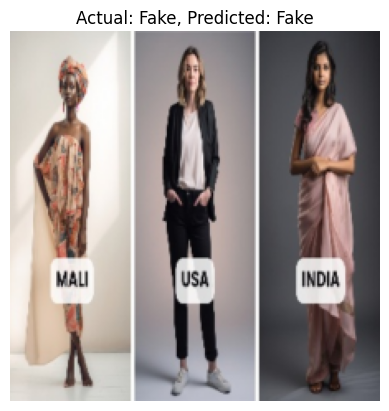

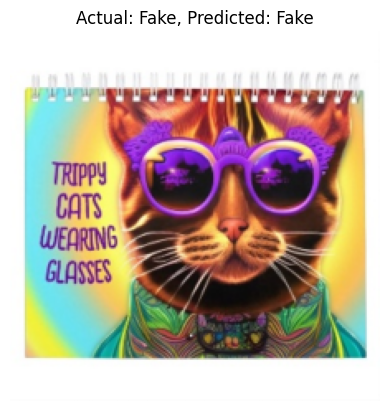

In [77]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

# Define the CustomDataset class
class CustomDataset(Dataset):
    def __init__(self, annotations, root_dir, transform=None):
        self.annotations = annotations
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Handle Subset object
        if isinstance(self.annotations, torch.utils.data.Subset):
            img_path = os.path.join(self.root_dir, self.annotations.dataset.annotations.iloc[idx, 0])
            label = self.annotations.dataset.annotations.iloc[idx, 1]
        else:
            img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
            label = self.annotations.iloc[idx, 1]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create a dataset and DataLoader for the test set
test_dataset = CustomDataset(testset, root_dir=extraction_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Define class labels
class_labels = ['Fake', 'Real']

def display_image_with_labels(image, actual_label, predicted_label):
    # Move tensor to CPU and convert it to numpy array
    image = image.cpu().detach().numpy().transpose((1, 2, 0))  # Channels-last format for matplotlib
    # Display the image
    plt.imshow(image)
    # Set title with actual and predicted labels
    plt.title(f"Actual: {class_labels[actual_label]}, Predicted: {class_labels[predicted_label]}")
    plt.axis('off')
    plt.show()


# Function to test the model on a few test images
# Function to test the model on a few test images
def test_model(model, test_loader, num_images=15):
    model.eval()
    count = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            if count >= num_images:
                break
            # Move inputs to the same device as the model
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            actual_label = labels.item()
            predicted_label = predicted.item()
            display_image_with_labels(inputs[0], actual_label, predicted_label)
            count += 1


# Test the model on a few test images
test_model(loaded_model, test_loader, num_images=15)


In [96]:
def test_model(model, test_loader, num_images_per_class=10):
    count_fake = 0
    count_real = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            if count_fake >= num_images_per_class and count_real >= num_images_per_class:
                break
                
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            actual_label = labels.item()  # Get the actual label
            predicted_label = predicted.item()
            print("Actual label:", actual_label)  # Print the actual label
            
            if actual_label == 0 and count_fake < num_images_per_class:
                display_image_with_labels(inputs[0], actual_label, predicted_label)
                count_fake += 1
            elif actual_label == 1 and count_real < num_images_per_class:
                display_image_with_labels(inputs[0], actual_label, predicted_label)
                count_real += 1


In [104]:
print(len(testloader))
class_0_count = 0
class_1_count = 0

for images, labels in testloader:
    # Count occurrences of class 0 and class 1 labels
    class_0_count += (labels == 0).sum().item()
    class_1_count += (labels == 1).sum().item()

print("Class 0 count:", class_0_count)
print("Class 1 count:", class_1_count)


294
Class 0 count: 1181
Class 1 count: 1170


In [145]:
def predict_single_image(model, image_path, device, class_labels=['Fake', 'Real']):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move the image to the same device as the model
    image = image.to(device)

    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        # Perform the prediction
        output = model(image)
        #prediction = torch.sigmoid(output).item()  # Assuming binary classification with Sigmoid activation
        prediction = output.item()
        
    # Convert prediction to label
    predicted_label = 1 if prediction >= 0.50 else 0

    ## Display the image with the predicted label
    #plt.imshow(Image.open(image_path))
    #plt.title(f'Predicted Label: {class_labels[predicted_label]} ({prediction:.2f})')
    #plt.axis('off')
    #plt.show()

    return predicted_label, prediction

In [146]:
error = 0
image_path = "/kaggle/working/ai_real_fake_dataset/Datasets/"
for i in range(1000):
    predicted_label, prediction = predict_single_image(alexnet, image_path+"Real/tiger_"+str(i+1)+".jpg", device)
    if(predicted_label==0):
        print(prediction)
        error = error+1 
    #print(f"Predicted Label: {predicted_label}, Prediction Score: {prediction:.2f}, Actual: Real")
    predicted_label, prediction = predict_single_image(alexnet, image_path+"Fake/ai generated tiger_"+str(i+1)+".jpg", device)
    if(predicted_label==1):
        print(prediction)
        error = error+1
    #print(f"Predicted Label: {predicted_label}, Prediction Score: {prediction:.2f}, Actual: Fake")
    
print(error)

0.5271782279014587
0.5271782279014587
0.5271782279014587
0.5271782279014587
0.5271782279014587
0.5271782279014587
0.5271782279014587
0.5271782279014587
0.5271782279014587
0.5271782279014587
0.5271782279014587
0.5271782279014587
12
